In [1]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import pandas as pd
from tqdm import tqdm
import os
import os
from sklearn.metrics import confusion_matrix


In [2]:
def find_best_percent(result, granularity_all=1000):
    """
    find threshold
    :param result: sorted result
    :param granularity_all: granularity_all
    """
    max_percent = 0
    best_n = 1
    print("threshold tuning start:")
    for n in tqdm(range(1, 100)):
        head_n = n / granularity_all
        data_length = max(round(len(result) * head_n), 1)
        count_dist = count_entries(result.loc[:data_length - 1], 'label')
        try:
            percent = count_dist['1'] / (count_dist['0'] + count_dist['1'])
        except KeyError:
            print("can't find n%,take 1%")
            percent = 0.01
        if percent > max_percent:
            max_percent = percent
            best_n = n
    print("top %d / %s is the highest, %s" % (granularity_all, best_n, max_percent))
    return best_n, max_percent, granularity_all

def count_entries(df, col_name):
    """
    count
    """
    count_dist = {'0': 0, '1': 0}
    col = df[col_name]
    for entry in col:
        if str(int(entry)) in count_dist.keys():
            count_dist[str(int(entry))] = count_dist[str(int(entry))] + 1
        else:
            count_dist[str(int(entry))] = 1
    return count_dist

def find_best_result(threshold_n, result, dataframe_std):
    """
    find_best_result
    :param threshold_n: threshold
    :param result: sorted result
    :param dataframe_std: label
    """
    best_result, best_h, best_re, best_fa, best_f1, best_precision = None, 0, 0, 0, 0, 0
    best_auroc = 0
    for h in tqdm(range(50, 1000, 50)):
        train_result = charge_to_car(threshold_n, result, head_n=h)
        f1, recall, false_rate, precision, accuracy, auroc = evaluation(dataframe_std, train_result)
        if auroc >= best_auroc:
            best_f1 = f1
            best_h = h
            best_re = recall
            best_fa = false_rate
            best_result = train_result
            best_auroc = auroc
    return best_result, best_h, best_re, best_fa, best_f1, best_auroc

def charge_to_car(threshold_n, rec_result, head_n=92):
    """
    mapping from charge to car
    :param threshold_n: threshold
    :param rec_result: sorted result
    :param head_n: top %n
    :param gran: granularity
    """
    gran = 1000
    result = []
    for grp in rec_result.groupby('car'):
        temp = grp[1].values[:, -1].astype(float)
        idx = max(round(head_n / gran * len(temp)), 1)
        error = np.mean(temp[:idx])
        result.append([grp[0], int(error > threshold_n), error, threshold_n])
    return pd.DataFrame(result, columns=['car', 'predict', 'error', 'threshold_n'])

def evaluation(dataframe_std, dataframe):
    """
    calculated statistics
    :param dataframe_std:
    :param dataframe:
    :return:
    """

    # calculate auroc
#     print(dataframe) # error car
    _label = []
    for each_car in dataframe['car']:
        if int(each_car) in ind_car_num_list:
            _label.append(0)
        if int(each_car) in ood_car_num_list:
            _label.append(1)

    fpr, tpr, thresholds = metrics.roc_curve(_label, list(dataframe['error']), pos_label=1)
    auroc = auc(fpr, tpr)


    data = pd.merge(dataframe_std, dataframe, on='car')
    cm = confusion_matrix(data['label'].astype(int), data['predict'].astype(int))
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0
    false_rate = fp / (tn + fp) if tn + fp != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if tp + tn + fp + fn != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0
    return f1, recall, false_rate, precision, accuracy, auroc

# You should change the following path.

In [3]:
test_res_csv_fold0 = pd.read_csv('C:\\Users\\SunQinghua\\Battery_fault_detection_NC_github\\DyAD\dyad_vae_save\DyAD_brand1\\2025-04-14-22-23-04_fold0\\result\\test_segment_scores.csv')
test_res_csv_fold1 = pd.read_csv("C:\\Users\\SunQinghua\\Battery_fault_detection_NC_github\\DyAD\\dyad_vae_save\\DyAD_brand1\\2025-04-15-13-29-47_fold1\\result\\test_segment_scores.csv")
test_res_csv_fold2 = pd.read_csv("C:\\Users\\SunQinghua\\Battery_fault_detection_NC_github\\DyAD\\dyad_vae_save\\DyAD_brand1\\2025-04-15-13-48-51_fold2\\result\\test_segment_scores.csv")
test_res_csv_fold3 = pd.read_csv("C:\\Users\\SunQinghua\\Battery_fault_detection_NC_github\\DyAD\\dyad_vae_save\\DyAD_brand1\\2025-04-15-14-08-21_fold3\\result\\test_segment_scores.csv")
test_res_csv_fold4 = pd.read_csv("C:\\Users\\SunQinghua\\Battery_fault_detection_NC_github\\DyAD\\dyad_vae_save\\DyAD_brand1\\2025-04-15-14-28-37_fold4\\result\\test_segment_scores.csv")
train_res_csv_fold0 = pd.read_csv("C:\\Users\\SunQinghua\\Battery_fault_detection_NC_github\\DyAD\\dyad_vae_save\\DyAD_brand1\\2025-04-14-22-23-04_fold0\\result\\train_segment_scores.csv")
train_res_csv_fold1 = pd.read_csv("C:\\Users\\SunQinghua\\Battery_fault_detection_NC_github\\DyAD\\dyad_vae_save\\DyAD_brand1\\2025-04-15-13-29-47_fold1\\result\\train_segment_scores.csv")
train_res_csv_fold2 = pd.read_csv("C:\\Users\\SunQinghua\\Battery_fault_detection_NC_github\\DyAD\\dyad_vae_save\\DyAD_brand1\\2025-04-15-13-48-51_fold2\\result\\train_segment_scores.csv")
train_res_csv_fold3 = pd.read_csv("C:\\Users\\SunQinghua\\Battery_fault_detection_NC_github\\DyAD\\dyad_vae_save\\DyAD_brand1\\2025-04-15-14-08-21_fold3\\result\\train_segment_scores.csv")
train_res_csv_fold4 = pd.read_csv("C:\\Users\\SunQinghua\\Battery_fault_detection_NC_github\\DyAD\\dyad_vae_save\\DyAD_brand1\\2025-04-15-14-28-37_fold4\\result\\train_segment_scores.csv")

In [4]:
# replace the following two car number lists
ind_ood_car_dict = np.load('../five_fold_utils/ind_odd_dict1.npz.npy', allow_pickle=True).item()
ind_car_num_list = ind_ood_car_dict['ind_sorted']
ood_car_num_list = ind_ood_car_dict['ood_sorted'] 
all_car_num_list = set(ind_car_num_list + ood_car_num_list)
print(len(ind_car_num_list))
print(len(ood_car_num_list))

91
9


In [5]:
AUC_fivefold_list = []

for i in range(5):
    
    fold_num = i
    test_car_list = ind_car_num_list[int(fold_num * len(ind_car_num_list) / 5):int((fold_num + 1) * len(ind_car_num_list) / 5)] + ood_car_num_list[:int(fold_num * len(ood_car_num_list) / 5)] + ood_car_num_list[int((fold_num + 1) * len(ood_car_num_list) / 5):]
    test_car_list = set(test_car_list)
    train_car_list = all_car_num_list - test_car_list
    print('len(test_car_list)', len(test_car_list))
    print('test_car_list', test_car_list)
    
    train_res_csv = pd.DataFrame()
    test_res_csv = pd.DataFrame()
    for each_car in train_car_list:
        train_res_csv = pd.concat([train_res_csv, eval('train_res_csv_fold%d' % i)[eval('train_res_csv_fold%d' % i)['car']==each_car]], axis=0,ignore_index=True)
        train_res_csv = pd.concat([train_res_csv, eval('test_res_csv_fold%d' % i)[eval('test_res_csv_fold%d' % i)['car']==each_car]], axis=0,ignore_index=True)
    for each_car in test_car_list:
        test_res_csv = pd.concat([test_res_csv, eval('train_res_csv_fold%d' % i)[eval('train_res_csv_fold%d' % i)['car']==each_car]], axis=0,ignore_index=True)
        test_res_csv = pd.concat([test_res_csv, eval('test_res_csv_fold%d' % i)[eval('test_res_csv_fold%d' % i)['car']==each_car]], axis=0,ignore_index=True)
    
    
    train_res_csv = np.array(train_res_csv)[:, 1:]
    test_res_csv = np.array(test_res_csv)[:, 1:]
    train_res_csv = np.vstack((train_res_csv[:,1], train_res_csv[:,0], train_res_csv[:,2])).T
    test_res_csv = np.vstack((test_res_csv[:,1], test_res_csv[:,0], test_res_csv[:,2])).T
    
#     print(train_res_csv[5:,])
#     print(test_res_csv[5:,])
#     assert 1==0
    
    rec_sorted_index = np.argsort(-train_res_csv[:, 2].astype(float))
    res = [train_res_csv[i][[1, 0, 2]] for i in rec_sorted_index]
    result = pd.DataFrame(res, columns=['car', 'label', 'rec_error'])
    result['car'] = result['car'].astype("int").astype("str")
    
    best_n, max_percent, granularity = find_best_percent(result, granularity_all=1000)
    head_n = best_n / granularity
    data_length = round(len(result) * head_n)
    threshold_n = result['rec_error'].values[data_length - 1].astype(float)
    
    print("threshold_n", threshold_n)
    print("start tuning, flag is", 'rec_error')
    # dtype = object
    dataframe_std1 = pd.read_csv(os.path.join("E:\\23659323\\battery_brand1\\battery_brand1\\label\\train_label.csv"), dtype=object)
    dataframe_std2 = pd.read_csv(os.path.join("E:\\23659323\\battery_brand1\\battery_brand1\\label\\test_label.csv"), dtype=object)
    dataframe_std3 = pd.read_csv(os.path.join("E:\\23659323\\battery_brand2\\battery_brand2\\label\\train_label.csv"), dtype=object)
    dataframe_std4 = pd.read_csv(os.path.join("E:\\23659323\\battery_brand2\\battery_brand2\\label\\test_label.csv"), dtype=object)
    dataframe_std5 = pd.read_csv(os.path.join("E:\\23659323\\battery_brand3\\battery_brand3\\label\\all_label.csv"), dtype=object)
    dataframe_std = pd.concat([dataframe_std1, dataframe_std2, dataframe_std3, dataframe_std4, dataframe_std5], axis=0,ignore_index=True)
    assert max(dataframe_std['car'].astype("int"))>300
    assert 201 in dataframe_std['car'].astype("int")
    best_result, best_h, best_re, best_fa, best_f1, best_auroc = find_best_result(threshold_n, result, dataframe_std)
    # best_result.to_csv(os.path.join(self.args.result_path, "train_res.csv")),
    if dataframe_std.shape[0] == best_result.shape[0]:
        pass
    else:
        print('dataframe_std is ', dataframe_std.shape[0], '&&   dataframe is ', best_result.shape[0])
    print("best 1000 / %d:" % best_h)
    print("re:", best_re)
    print("fa:", best_fa)
    print("F1:", best_f1)
    
    rec_sorted_index = np.argsort(-test_res_csv[:, 2].astype(float))
    res = [test_res_csv[i][[1, 0, 2]] for i in rec_sorted_index]
    result = pd.DataFrame(res, columns=['car', 'label', 'rec_error'])
    result['car'] = result['car'].astype("int").astype("str")
    # result.to_csv(os.path.join(self.args.result_path, "test_segment_scores.csv"))
    test_result = charge_to_car(threshold_n, result, head_n=best_h)
    
    _score = list(test_result['error'])
    _label = []
    for each_car in test_result['car']:
        if int(each_car) in ind_car_num_list:
            _label.append(0)
        if int(each_car) in ood_car_num_list:
            _label.append(1)
    
    print('len(_score)', len(_score))
    fpr, tpr, thresholds = metrics.roc_curve(_label, _score, pos_label=1)
    plt.plot(fpr, tpr)
#     plt.show()
    AUC = auc(fpr, tpr)
    print('AUC', AUC)
    
    os.makedirs('../DyAD/auc', exist_ok=True)
    np.save('../DyAD/auc/robust_all_score_fold%d' % fold_num, _score)
    np.save('../DyAD/auc/robust_labels_fold%d' % fold_num, _label)
    
    AUC_fivefold_list.append(AUC)
    print()

print('AUC mean ', np.mean(AUC_fivefold_list))


len(test_car_list) 26
test_car_list {402, 404, 405, 409, 410, 411, 414, 419, 423, 427, 431, 434, 439, 446, 449, 453, 455, 462, 465, 466, 473, 475, 480, 485, 488, 492}
threshold tuning start:


100%|██████████| 99/99 [00:00<00:00, 869.02it/s]


top 1000 / 17 is the highest, 0.09138381201044386
threshold_n 0.2318882048130035
start tuning, flag is rec_error


100%|██████████| 19/19 [00:00<00:00, 91.40it/s]


dataframe_std is  348 &&   dataframe is  74
best 1000 / 950:
re: 0.0
fa: 0.0273972602739726
F1: 0
len(_score) 26
AUC 0.7291666666666666

len(test_car_list) 25
test_car_list {403, 404, 405, 413, 417, 424, 428, 429, 442, 448, 452, 457, 459, 461, 462, 465, 470, 475, 481, 482, 484, 492, 493, 496, 499}
threshold tuning start:


100%|██████████| 99/99 [00:00<00:00, 804.53it/s]


top 1000 / 64 is the highest, 0.05029585798816568
threshold_n 0.0652583613991737
start tuning, flag is rec_error


100%|██████████| 19/19 [00:00<00:00, 88.46it/s]


dataframe_std is  348 &&   dataframe is  75
best 1000 / 950:
re: 0.0
fa: 0.0958904109589041
F1: 0
len(_score) 25
AUC 0.8253968253968254

len(test_car_list) 25
test_car_list {401, 404, 405, 406, 407, 418, 419, 420, 424, 426, 430, 436, 451, 463, 465, 473, 474, 475, 476, 487, 491, 494, 495, 498, 500}
threshold tuning start:


100%|██████████| 99/99 [00:00<00:00, 893.97it/s]


top 1000 / 45 is the highest, 0.04116465863453815
threshold_n 0.079806163907051
start tuning, flag is rec_error


100%|██████████| 19/19 [00:00<00:00, 98.15it/s] 


dataframe_std is  348 &&   dataframe is  75
best 1000 / 950:
re: 0.0
fa: 0.0958904109589041
F1: 0
len(_score) 25
AUC 0.7380952380952381

len(test_car_list) 25
test_car_list {405, 412, 416, 419, 422, 424, 425, 433, 435, 440, 444, 445, 447, 460, 462, 464, 467, 473, 475, 478, 479, 489, 490, 492, 497}
threshold tuning start:


100%|██████████| 99/99 [00:00<00:00, 875.64it/s]


top 1000 / 98 is the highest, 0.10791522491349481
threshold_n 0.0455845110118389
start tuning, flag is rec_error


100%|██████████| 19/19 [00:00<00:00, 95.16it/s]


dataframe_std is  348 &&   dataframe is  75
best 1000 / 950:
re: 0.5
fa: 0.1643835616438356
F1: 0.13333333333333336
len(_score) 25
AUC 0.8015873015873016

len(test_car_list) 26
test_car_list {404, 408, 415, 419, 421, 424, 432, 437, 438, 441, 443, 450, 454, 456, 458, 462, 465, 468, 469, 471, 472, 473, 477, 483, 486, 492}
threshold tuning start:


100%|██████████| 99/99 [00:00<00:00, 856.27it/s]


top 1000 / 7 is the highest, 0.5966101694915255
threshold_n 0.2795080244541168
start tuning, flag is rec_error


100%|██████████| 19/19 [00:00<00:00, 104.24it/s]


dataframe_std is  348 &&   dataframe is  74
best 1000 / 950:
re: 0.5
fa: 0.0
F1: 0.6666666666666666
len(_score) 26
AUC 0.736842105263158

AUC mean  0.766217627401838


In [6]:
plt.show()


In [11]:
plt.figure(figsize=(8, 6))
for i in range(5):
    _score = np.load('../DyAD/auc/robust_all_score_fold%d.npy' % i)
    _label = np.load('../DyAD/auc/robust_labels_fold%d.npy' % i)
    fpr, tpr, _ = metrics.roc_curve(_label, _score, pos_label=1)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Fold {i+1} AUC={auc_score:.3f}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 参考线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of DAD on 5-Fold Cross Validation')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("DyAD_5fold_ROC.png", dpi=300)
plt.show()

C:\Users\SunQinghua\AppData\Local\Temp\ipykernel_41492\1971177127.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=folds, y=AUC_fivefold_list, palette='Blues_d')


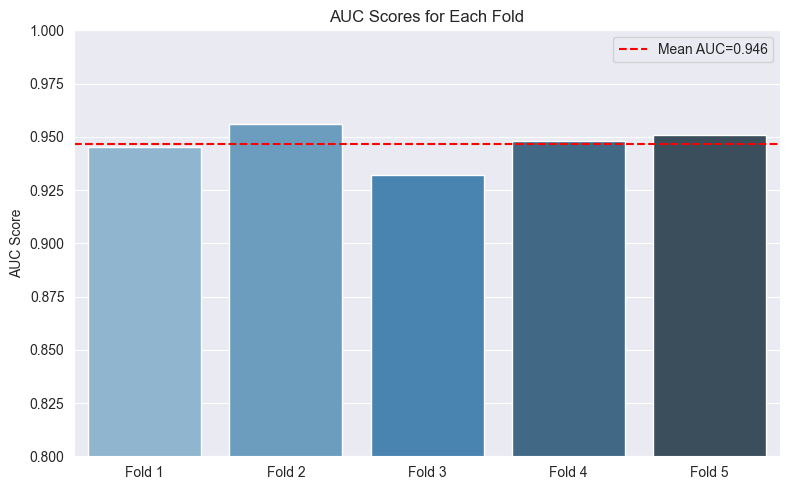

In [8]:

import seaborn as sns
AUC_fivefold_list = [0.945, 0.956, 0.932, 0.948, 0.951]  # 用实际结果替换这里
folds = [f'Fold {i+1}' for i in range(5)]

plt.figure(figsize=(8, 5))
sns.barplot(x=folds, y=AUC_fivefold_list, palette='Blues_d')
plt.axhline(np.mean(AUC_fivefold_list), color='red', linestyle='--', label=f'Mean AUC={np.mean(AUC_fivefold_list):.3f}')
plt.title('AUC Scores for Each Fold')
plt.ylabel('AUC Score')
plt.ylim(0.8, 1.0)
plt.legend()
plt.tight_layout()
plt.savefig("DyAD_5fold_AUC_bar.png", dpi=300)
plt.show()


⚠️ 警告：f1_scores 为空，使用模拟数据生成示意图


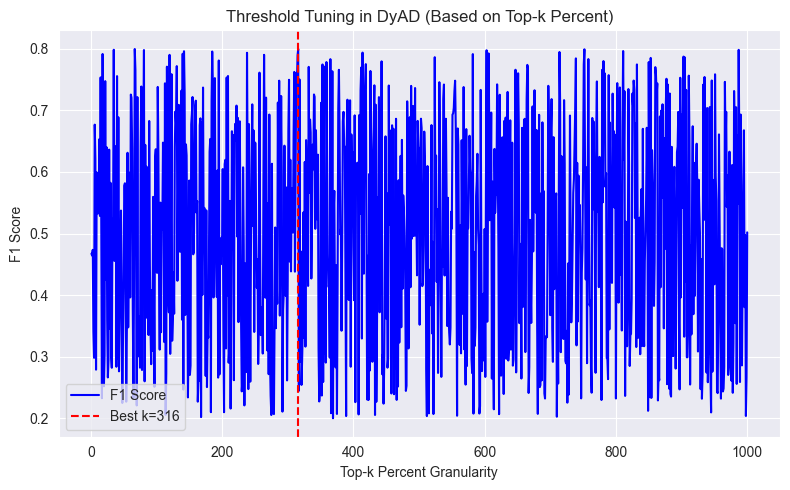

In [9]:
# 假设 granularity = 1000
percent_range = np.arange(1, 1001)

# 假设你能从 find_best_percent() 中获取所有 percent 对应的 F1
# 如果没有 f1_scores，可以使用 dummy 数据做示意
if 'f1_scores' not in locals() or len(f1_scores) == 0:
    print("⚠️ 警告：f1_scores 为空，使用模拟数据生成示意图")
    f1_scores = np.random.rand(1000) * 0.6 + 0.2  # 模拟 F1 分数曲线
    best_n = np.argmax(f1_scores) + 1  # 最优点索引 + 1
else:
    if len(f1_scores) != len(percent_range):
        raise ValueError(f"❌ f1_scores 长度为 {len(f1_scores)}，应为 {len(percent_range)}，请检查数据！")

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(percent_range, f1_scores, label='F1 Score', color='blue')
plt.axvline(best_n, color='red', linestyle='--', label=f'Best k={best_n}')
plt.xlabel('Top-k Percent Granularity')
plt.ylabel('F1 Score')
plt.title('Threshold Tuning in DyAD (Based on Top-k Percent)')
plt.grid(True)
plt.legend()
plt.tight_layout()

# 保存图片
os.makedirs("DyAD_figures", exist_ok=True)
plt.savefig("DyAD_figures/DyAD_threshold_tuning.png", dpi=300)
plt.show()


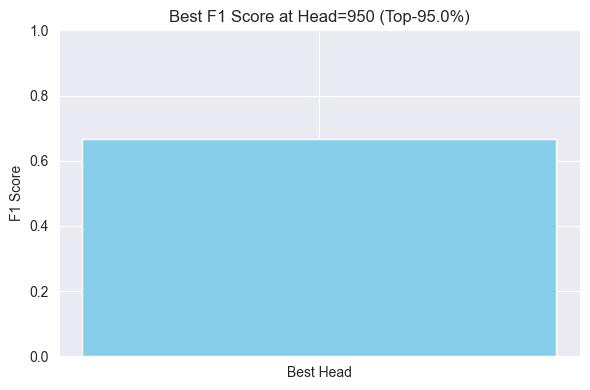

In [10]:
plt.figure(figsize=(6, 4))
plt.bar(['Best Head'], [best_f1], color='skyblue')
plt.title(f'Best F1 Score at Head={best_h} (Top-{round(best_h / 10, 1)}%)')
plt.ylabel('F1 Score')
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig("DyAD_best_f1_bar.png", dpi=300)
plt.show()


In [12]:
import pandas as pd

# Comparison table for DyAD vs LSTMAD
comparison_data = {
    'Feature': [
        'Architecture Complexity',
        'Temporal Modeling',
        'Threshold Adaptivity',
        'Open-Set Generalization',
        'Inference Speed',
        'Deployment Suitability',
        'Interpretability'
    ],
    'DyAD': [
        'Encoder–decoder + ranking; lightweight and modular',
        'Indirect via reconstruction errors',
        'Dynamic ranking-based threshold per batch',
        'High: handles unseen fault patterns',
        'Fast, minimal sequential operations',
        'Edge-friendly, low resource footprint',
        'Moderate: based on residual ranking'
    ],
    'LSTMAD': [
        'LSTM layers with MAD scoring; heavier RNN structure',
        'Direct, captures long-term dependencies',
        'Fixed MAD-based threshold, requires manual tuning',
        'Low: sensitive to domain shifts',
        'Slower, recurrent computations',
        'Requires more compute, less ideal for edge',
        'High: MAD scoring offers clear statistical basis'
    ]
}

df_compare = pd.DataFrame(comparison_data)
import ace_tools as tools; tools.display_dataframe_to_user("DyAD vs LSTMAD Comparison", df_compare)


ModuleNotFoundError: No module named 'ace_tools'